# Tax Calculations
⚠️ Fair possibility of methodological flaw
⚠️ Only considering surface lots

In [1]:
import osmnx as ox
import geopandas as gpd
ox.config(use_cache=False)
ox.__version__

'0.15.1'

## Load Tax Roll/Parcel Data

Load in all the [parcels on the tax role](https://webgis.providenceri.gov/server/rest/services/Tax/Parcels/MapServer), and set to the correct CRS. This file was prepared in QGIS, in the `tax-data/Downtown Tax Parcels.qgz` file.

In [2]:
parcels = gpd.read_file("tax-data/Downtown-Parcels.geojson").to_crs(26919)

Let's take a look at what's in that file:

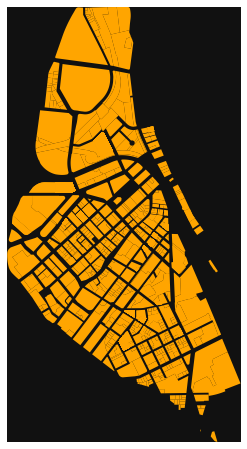

,OBJECTID,CAMAExtract_PlatNum,CAMAExtract_BlockNum,CAMAExtract_LotNum,CAMAExtract_SubLotNum,CAMAExtract_UnitNum,CAMAExtract_ParcAddress,CAMAExtract_Owner1,CAMAExtract_OwnerAddress,CAMAExtract_OwnerCity,...,CAMAExtract_AssessedValueTotal,CAMAExtract_AssessedValueLand,CAMAExtract_AssessedValueBuildi,CAMAExtract_MuniUseCode,CAMAExtract_MuniUseCodeDesc,CAMAExtract_AreaSF,PLAN_ID,CAMA_ID,ZONING,geometry
0,256,12,,33,,,17 South Main,State of Rhode Island,2 EXCHANGE Ter,PROVIDENCE,...,384100.0,384100.0,0.0,913,State Land Res,3549.0,12.tif,01200330000,None,"MULTIPOLYGON (((300059.679 4633165.648, 300059..."
1,270,12,,31,,,13 South Main,City of Providence,City Hall,Providence,...,383700.0,383700.0,0.0,920,Mun Lnd Com,3484.0,12.tif,01200310000,None,"MULTIPOLYGON (((300055.481 4633173.780, 300055..."
2,642,12,,1,,REVO,20 Washingon St,RI School of Design,2 COLLEGE ST,PROVIDENCE,...,14955400.0,1628700.0,13130600.0,933,School (94),26229.0,12.tif,None,None,"MULTIPOLYGON (((299938.870 4633415.808, 299954..."
3,3551,12,,470,,,161 South Main,RI School of Design,2 COLLEGE ST,PROVIDENCE,...,8707300.0,1228100.0,7286800.0,933,Public School,17209.0,12.tif,01204700000,None,"MULTIPOLYGON (((300185.943 4632942.488, 300148..."
4,3597,12,,73,,,155 South Main,Atlantic Enterprises,,Providence,...,6178400.0,1351800.0,4605600.0,218,Office,20144.0,12.tif,01200730000,None,"MULTIPOLYGON (((300160.178 4632979.200, 300122..."


In [3]:
ox.plot_footprints(parcels)
parcels.head()

The parcels include some `'Paid Prkg Lot'`s, which have assessed values. We will separate out these entries from all others:

In [4]:
parcelsParking = parcels[parcels['CAMAExtract_MuniUseCodeDesc'] == 'Paid Prkg Lot']
parcelsOther = parcels[parcels['CAMAExtract_MuniUseCodeDesc'] != 'Paid Prkg Lot']

## Download Surface Parking from OSM

See `make.ipynb` for more details on this process.

In [7]:
place = "Downtown, Providence, RI, USA"

footprint_type = "parking"

osm_unprojected = ox.footprints.footprints_from_place(place, footprint_type=footprint_type)
osm = ox.project_gdf(osm_unprojected).to_crs(26919)
osm = osm[osm['parking'] == "surface"]

## What are we working with?

We have a list of parcels that have been assessed with values. We know for a fact that some of these are paid parking lots, as they are indicated as such. The problem, however, is that there are a lot of parking lots (especially unpaid ones) which are considered vacant land, not parking ([this one](http://gis.vgsi.com/providenceri/Parcel.aspx?Pid=33865), for example).

We have a much more detailed dataset from OSM. In the figure below, green areas are those in the OSM dataset, red areas are in the tax roll as parking lots, and orange areas are in both. Notice that there are effectively no red areas, so the paid parking parcels in the tax data are a subset of our OSM areas.

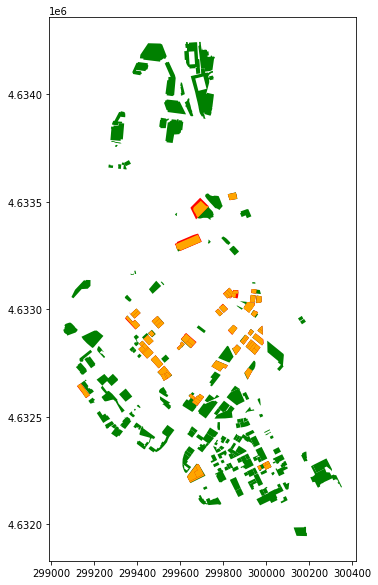

In [20]:
osm_in_parcelsParking = gpd.overlay(osm, parcelsParking, how='intersection')

ax = osm.plot(color='green', figsize=(10,10))
parcelsParking.plot(ax=ax, color='red')
osm_in_parcelsParking.plot(ax=ax, color='orange')

We can also look at all parcels that are not explicitly paid parking (yellow), OSM areas that are **not** in a parking tax role entry (purple), and areas that are in both (blue). Note that because there is almost no purple visible, we know that almost all of the areas in OSM which are not explicitly marked as parking lots on the tax roles are also located inside of other parcels. Very little OSM parking data is located outside of a tax role parcel.

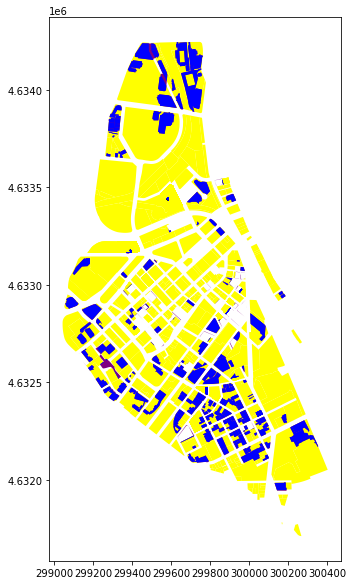

In [26]:
osm_not_parcelsParking = gpd.overlay(osm, parcelsParking, how='difference')
osm_in_parcelsOther = gpd.overlay(osm_not_parcelsParking, parcelsOther, how='intersection')

ax = parcelsOther.plot(color='yellow', figsize=(10,10))
osm_not_parcelsParking.plot(ax=ax, color='purple')
osm_in_parcelsOther.plot(ax=ax, color='blue')

In [32]:
osm_in_parcelsOther.CAMA_ID.unique()

array(['01901130000', '01901190000', '01901140000', '02501480000',
       '02501450000', '02501470000', '02504660000', '00305170000',
       '02603490000', '00401890000', '01901370000', '00303440000',
       '00304910000', '00303470000', '00303800000', '00303810000',
       '00303260000', '00303270000', '00303150000', '00303160000',
       '00303820000', '00303530000', '00303510000', '00303520000',
       '00402310000', '01900330000', '02000350000', '02000480000', None,
       '02002050000', '02003930000', '02002930000', '02004010000',
       '0203870000', '02003680000', '02504600000', '02504590000',
       '02104030000', '02104020000', '02103430000', '02104370000',
       '02104010000', '02102760000', '02102770000', '02102780000',
       '02503300000', '02503290000', '02001890000', '02003780000',
       '02103130000', '02102890000', '02102870000', '02104430000',
       '02103020000', '02103030000', '02103040000', '02103050000',
       '02104000000', '02101740000', '02101730000', '0210

In [39]:
len(parcels)

1128

In [50]:
len(parcels.OBJECTID.unique())

1128

In [41]:
parcels.columns

Index(['OBJECTID', 'CAMAExtract_PlatNum', 'CAMAExtract_BlockNum',
       'CAMAExtract_LotNum', 'CAMAExtract_SubLotNum', 'CAMAExtract_UnitNum',
       'CAMAExtract_ParcAddress', 'CAMAExtract_Owner1',
       'CAMAExtract_OwnerAddress', 'CAMAExtract_OwnerCity',
       'CAMAExtract_OwnerState', 'CAMAExtract_OwnerZip',
       'CAMAExtract_OwnerCountry', 'CAMAExtract_AssessedValueTotal',
       'CAMAExtract_AssessedValueLand', 'CAMAExtract_AssessedValueBuildi',
       'CAMAExtract_MuniUseCode', 'CAMAExtract_MuniUseCodeDesc',
       'CAMAExtract_AreaSF', 'PLAN_ID', 'CAMA_ID', 'ZONING', 'geometry'],
      dtype='object')

In [53]:
len(osm_in_parcelsOther)

873

In [71]:
f = osm_in_parcelsOther[['OBJECTID', 'CAMAExtract_ParcAddress', 'geometry', 'CAMAExtract_AreaSF']]
f

,OBJECTID,CAMAExtract_ParcAddress,geometry,CAMAExtract_AreaSF
0,41978,6 Moshassuck Ct,"POLYGON ((299777.270 4633526.790, 299779.359 4...",23782.0
1,42812,10 Finance Way,"POLYGON ((299721.629 4633536.108, 299724.365 4...",22360.0
2,39421,5 Moshassuck Ct,"POLYGON ((299731.553 4633476.694, 299732.584 4...",34967.0
3,20078,32 Fountain St,"POLYGON ((299480.413 4633079.522, 299471.816 4...",3825.0
4,21558,1 Eddy St,"POLYGON ((299488.712 4633132.717, 299511.451 4...",11915.0
...,...,...,...,...
868,41359,1 Chestnut St,"POLYGON ((299557.438 4632543.728, 299547.496 4...",0.0
869,42188,48 Orms St,"POLYGON ((299627.111 4634243.968, 299634.909 4...",43560.0
870,42188,48 Orms St,"MULTIPOLYGON (((299698.189 4634096.398, 299698...",43560.0
871,41133,2 Charles St,"POLYGON ((299735.009 4634054.654, 299734.883 4...",22726.0


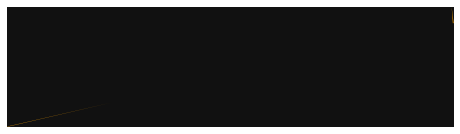

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe11cb2e890>)

In [85]:
ox.plot_footprints(f[f['OBJECTID'] == 42188].tail(1))

In [84]:
f[f['OBJECTID'] == 42188].tail(1)

,OBJECTID,CAMAExtract_ParcAddress,geometry,CAMAExtract_AreaSF
870,42188,48 Orms St,"MULTIPOLYGON (((299698.189 4634096.398, 299698...",43560.0


RangeIndex(start=0, stop=873, step=1)